# Environment

In [101]:
import numpy as np
import operator
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [102]:
# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Run this cell for more readable visuals 
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.style.use('seaborn-whitegrid')
plt.rcParams.update(params)
#sns.set_style("white")
%matplotlib inline

# Data input
Input policy and case data respectively.

In [103]:
# import policy file
df_policy = pd.read_excel(r"E:\Dropbox (MIT)\2020Fall\CS109A Data Science\group assignment\CS109A_Group58\02_Data\03_Policy\COVID_StatePolicy_final.xlsx")

In [104]:
df_policy.head()

,state,state_code,state_fips,emergency,stay_at_home,gathering,end_stay_at_home,close_school,close_nonessential_business,close_restaurant,close_gym,close_theater,close_bar,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask
0,Alabama,AL,1,2020-03-13,2020-04-04,0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
1,Alaska,AK,2,2020-03-11,2020-03-28,0,2020-04-24,2020-03-16,2020-03-24,2020-03-18,2020-03-18,2020-03-18,2020-03-18,2020-04-24,2020-04-24,2020-05-08,2020-05-08,2020-05-08,2020-04-24
2,Arizona,AZ,4,2020-03-11,2020-03-31,1,2020-05-16,2020-03-16,2020-03-31,2020-03-21,2020-03-21,2020-03-21,2020-03-21,2020-05-08,2020-05-11,2020-05-13,2020-05-16,2020-05-16,NaT
3,Arkansas,AR,5,2020-03-11,NaT,0,NaT,2020-03-17,2020-04-06,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-05-04,2020-05-11,2020-05-04,2020-05-18,2020-05-19,2020-07-20
4,California,CA,6,2020-03-04,2020-03-19,0,NaT,2020-03-23,2020-03-19,2020-03-16,2020-03-19,2020-03-19,2020-03-16,2020-05-08,2020-05-18,NaT,NaT,NaT,2020-06-18


In [105]:
# import COVID case file
df_case = pd.read_csv(r"E:\Dropbox (MIT)\2020Fall\CS109A Data Science\group assignment\CS109A_Group58\02_Data\01_COVID\covid_us_county.csv")

In [106]:
df_case.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-26,0,AL,0


In [107]:
df_case.describe()

,fips,lat,long,cases,deaths
count,942390.000,945220.000,945220.000,945220.000,945220.000
mean,33061.685,36.707,-88.601,898.875,31.174
std,18636.152,9.062,21.716,5354.237,229.454
min,60.000,-14.271,-174.160,0.000,0.000
25%,19079.000,33.896,-97.790,0.000,0.000
50%,31014.000,38.002,-89.487,34.000,0.000
75%,47131.000,41.573,-82.311,302.000,6.000
max,99999.000,69.315,145.674,306327.000,7400.000


In [129]:
# merge the data
df_merge=df_case.merge(df_policy, on=['state_code','state'],how='left')

In [130]:
df_merge.head()

,fips,county,state,lat,long,date,cases,state_code,deaths,state_fips,emergency,stay_at_home,gathering,end_stay_at_home,close_school,close_nonessential_business,close_restaurant,close_gym,close_theater,close_bar,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask
0,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-22,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
1,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-23,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
2,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-24,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
3,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-25,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
4,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-26,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16


# Data cleaning

## Case data
(1) Generate daily increase;
<br>(2) Clean the observations with negative increase;
<br>(3) Calculate 7-day moving average of new cases.

In [131]:
# get daily data from cumulative sum
df_merge['new_cases']=df_merge['cases'].groupby(df_merge['fips']).diff().fillna(0)
df_merge['new_deaths']=df_merge['deaths'].groupby(df_merge['fips']).diff().fillna(0)

In [132]:
# impute 0 for dates with negative case inceases
df_merge['new_cases']=df_merge['new_cases'].clip(lower=0)
df_merge['new_deaths']=df_merge['new_deaths'].clip(lower=0)

In [133]:
df_merge['cases_7day_ave'] = df_merge.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

## Policy data
Code dummy variables for the key policies (i.e.,'stay_at_home','close_school','close_nonessential_business','close_restaurant','facemask')

In [134]:
df_merge['policy_home']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['stay_at_home'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['end_stay_at_home'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_school']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_school'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_business']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_nonessential_business'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_business'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_restaurant']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_restaurant'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_restaurant'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_facemask']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['facemask'].astype('datetime64[ns]')), 1, 0)

# Univariate visualizations

## Cases

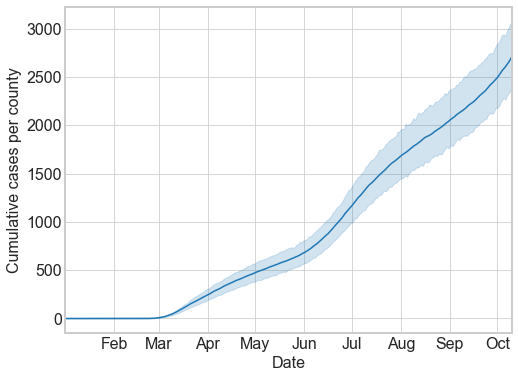

In [14]:
# cumulative cases
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases",
             data=df_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Cumulative cases per county')
plt.show()

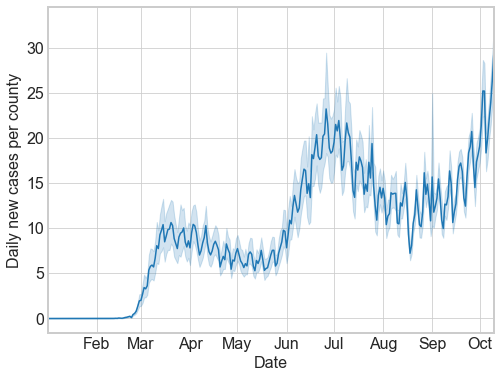

In [15]:
# new cases
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="new_cases",
             data=df_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.show()

We see a clear weekly circular patterns in the newly confirmed cases.

## Policies

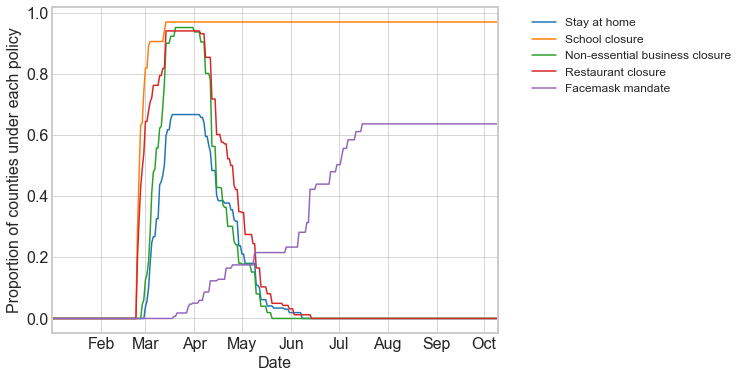

In [16]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="policy_home",ci=None,label="Stay at home",
             data=df_merge)
sns.lineplot(x="date", y="policy_school",ci=None,label="School closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_business",ci=None,label="Non-essential business closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_restaurant",ci=None,label="Restaurant closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_facemask",ci=None,label="Facemask mandate",
             data=df_merge)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Proportion of counties under each policy')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

# Correlational Analysis

Plot the case growth by early and late adopter of "Stay-at-home"/"Shelter-in-place" policy.

In [135]:
medium_order=df_merge['stay_at_home'].astype('datetime64[ns]').quantile(.5)
df_merge['early_adopter']=np.where((df_merge['stay_at_home'].astype('datetime64[ns]')<medium_order)
                                   & df_merge['stay_at_home'].notna()==True,1,0)
df_merge['late_adopter']=np.where((df_merge['stay_at_home'].astype('datetime64[ns]')>=medium_order)
                                   & df_merge['stay_at_home'].notna()==True,1,0)
df_merge['never_adopter']=np.where(df_merge['stay_at_home'].notna()==False,1,0)

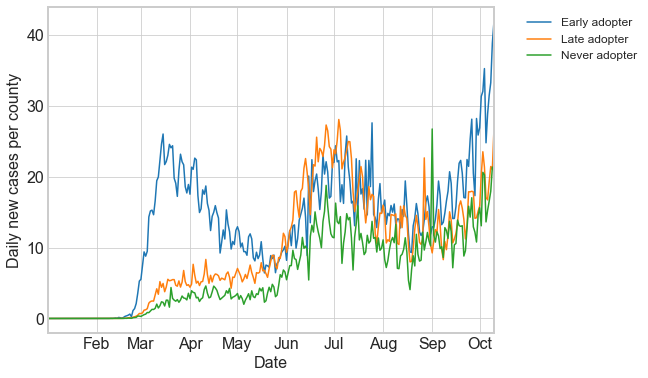

In [136]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="new_cases",ci=None,label="Early adopter",
             data=df_merge[df_merge['early_adopter']==1])
sns.lineplot(x="date", y="new_cases",ci=None,label="Late adopter",
             data=df_merge[df_merge['late_adopter']==1])
sns.lineplot(x="date", y="new_cases",ci=None,label="Never adopter",
             data=df_merge[df_merge['never_adopter']==1])

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

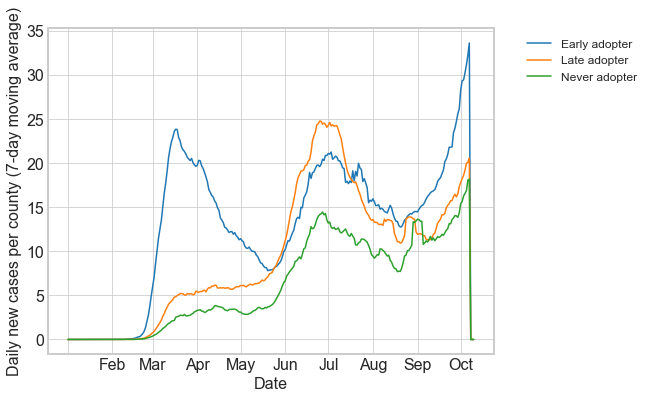

In [137]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases_7day_ave",ci=None,label="Early adopter",
             data=df_merge[df_merge['early_adopter']==1])
sns.lineplot(x="date", y="cases_7day_ave",ci=None,label="Late adopter",
             data=df_merge[df_merge['late_adopter']==1])
sns.lineplot(x="date", y="cases_7day_ave",ci=None,label="Never adopter",
             data=df_merge[df_merge['never_adopter']==1])

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county (7-day moving average)')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

Normalize cases at March 28 (i.e., the median date of stay-at-home order) to document the relative change in cases.

In [164]:
df_complete=df_merge.dropna(subset=['cases_7day_ave'])
x=df_complete[['policy_home','policy_school','policy_business','policy_restaurant','policy_facemask']]
y=df_complete['cases_7day_ave']

model = LinearRegression()
model.fit(x,y)
print(model.coef_)

[ 5.43353908  9.02239145  2.18933824 -6.0728611   6.26736568]


In [165]:
import statsmodels.formula.api as sm
normal_ols = sm.ols(formula='cases_7day_ave ~ policy_home + policy_school+ policy_business+ policy_restaurant+ policy_facemask',
                          data=df_complete).fit()
print(normal_ols.summary())


                            OLS Regression Results                            
Dep. Variable:         cases_7day_ave   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2169.
Date:                Thu, 05 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:10:12   Log-Likelihood:            -5.0813e+06
No. Observations:              942390   AIC:                         1.016e+07
Df Residuals:                  942384   BIC:                         1.016e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7567      0.11

In [169]:
!pip3 install linearmodels

In [206]:
from linearmodels.panel import PanelOLS

df_complete['log_new_cases']=np.log(df_complete['new_cases']+1)
df_complete['log_case_diff']=df_complete['log_new_cases'].groupby(df_complete['fips']).diff().fillna(0)
df_complete['date']=pd.to_datetime(df_complete['date'],format='%Y-%m-%d')

panel_data = df_complete[(df_complete['date']>=pd.to_datetime("2020-03-01",format='%Y-%m-%d')) &
                             (df_complete['date']<=pd.to_datetime("2020-05-30",format='%Y-%m-%d'))].set_index(['fips', 'date'])
panel_data.head()

C:\Users\yichu\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yichu\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yichu\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

county    state    lat    long  cases state_code  deaths  \
fips   date                                                                    
1001.0 2020-03-01  Autauga  Alabama  32.54 -86.644    0.0         AL     0.0   
       2020-03-02  Autauga  Alabama  32.54 -86.644    0.0         AL     0.0   
       2020-03-03  Autauga  Alabama  32.54 -86.644    0.0         AL     0.0   
       2020-03-04  Autauga  Alabama  32.54 -86.644    0.0         AL     0.0   
       2020-03-05  Autauga  Alabama  32.54 -86.644    0.0         AL     0.0   

                   state_fips  emergency stay_at_home  gathering  \
fips   date                                                        
1001.0 2020-03-01         1.0 2020-03-13   2020-04-04        0.0   
       2020-03-02         1.0 2020-03-13   2020-04-04        0.0   
       2020-03-03         1.0 2020-03-13   2020-04-04        0.0   
       2020-03-04         1.0 2020-03-13   2020-04-04        0.0   
       2020-03-05         1.0 2020-03-13   2020-04-04        0.0   

                  end_stay_at_home close_school close_nonessential_business  \
fips   date                                                                   
1001.0 2020-03-01       2020-04-30   2020-03-20                  2020-03-28   
       2020-03-02       2020-04-30   2020-03-20                  2020-03-28   
       2020-03-03       2020-04-30   2020-03-20                  2020-03-28   
       2020-03-04       2020-04-30   2020-03-20                  2020-03-28   
       2020-03-05       2020-04-30   2020-03-20                  2020-03-28   

                  close_restaurant  close_gym close_theater  close_bar  \
fips   date                                                              
1001.0 2020-03-01       2020-03-19 2020-03-28    2020-03-28 2020-03-19   
       2020-03-02       2020-03-19 2020-03-28    2020-03-28 2020-03-19   
       2020-03-03       2020-03-19 2020-03-28    2020-03-28 2020-03-19   
       2020-03-04       2020-03-19 2020-03-28    2020-03-28 2020-03-19   
       2020-03-05       2020-03-19 2020-03-28    2020-03-28 2020-03-19   

                  reopen_business reopen_restaurant reopen_gym reopen_theater  \
fips   date                                                                     
1001.0 2020-03-01      2020-04-30        2020-05-11 2020-05-11     2020-05-22   
       2020-03-02      2020-04-30        2020-05-11 2020-05-11     2020-05-22   
       2020-03-03      2020-04-30        2020-05-11 2020-05-11     2020-05-22   
       2020-03-04      2020-04-30        2020-05-11 2020-05-11     2020-05-22   
       2020-03-05      2020-04-30        2020-05-11 2020-05-11     2020-05-22   

                  reopen_bar   facemask  new_cases  new_deaths  \
fips   date                                                      
1001.0 2020-03-01 2020-05-11 2020-07-16        0.0         0.0   
       2020-03-02 2020-05-11 2020-07-16        0.0         0.0   
       2020-03-03 2020-05-11 2020-07-16        0.0         0.0   
       2020-03-04 2020-05-11 2020-07-16        0.0         0.0   
       2020-03-05 2020-05-11 2020-07-16        0.0         0.0   

                   cases_7day_ave  policy_home  policy_school  \
fips   date                                                     
1001.0 2020-03-01             0.0          0.0            0.0   
       2020-03-02             0.0          0.0            0.0   
       2020-03-03             0.0          0.0            0.0   
       2020-03-04             0.0          0.0            0.0   
       2020-03-05             0.0          0.0            0.0   

                   policy_business  policy_restaurant  policy_facemask  \
fips   date                                                              
1001.0 2020-03-01              0.0                0.0              0.0   
       2020-03-02              0.0                0.0              0.0   
       2020-03-03              0.0                0.0              0.0   
       2020-03-04              0.0                0.

In [209]:
x=panel_data[['policy_home','policy_school','policy_business','policy_restaurant','policy_facemask']]
y=panel_data['log_case_diff']
reg  = PanelOLS(y,x, entity_effects=True)
print(reg.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:          log_case_diff   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0060
No. Observations:              303030   R-squared (Within):               0.0001
Date:                Thu, Nov 05 2020   R-squared (Overall):              0.0001
Time:                        22:42:55   Log-likelihood                -3.064e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.3190
Entities:                        3330   P-value                           0.0000
Avg Obs:                       91.000   Distribution:                F(5,299695)
Min Obs:                       91.000                                           
Max Obs:                       91.000   F-statistic (robust):             6.3190
                            